# Clustering
## Input
We will cluster the sequences using MMseqs2. First we need to combine the sequences we downloaded into one file.

In [16]:
import os
from Bio import SeqIO
from collections import defaultdict
import glob
import matplotlib.pyplot as plt
import subprocess
import shutil
import dendropy
import pandas as pd
import toyplot.pdf

In [5]:
seq_file = "all_proteins_combined.fasta"
data_dir = "../data"
cluster_file = "mmseqs_output_cluster.tsv"
path_raw_gene_families = "../raw_gene_families"
path_clean_families = "../filtered_gene_families"

In [6]:
#combine all fasta files for mmseqs

print(f"Creating {seq_file}...")

with open(seq_file, "w") as outfile:
    count = 0
    for filename in os.listdir(data_dir):
        if filename.endswith(".faa"):
            #use filename as species label (like Bifidobacterium_longum)
            species_tag = filename.replace(".faa", "")
            
            with open(os.path.join(data_dir, filename), "r") as infile:
                for line in infile:
                    if line.startswith(">"):
                        
                        original_id = line.split()[0].lstrip(">")
                        outfile.write(f">{species_tag}|{original_id}\n")
                    else:
                        outfile.write(line)
            count += 1

print(f"Merged {count} genomes into {seq_file}")

Creating all_proteins_combined.fasta...
Merged 55 genomes into all_proteins_combined.fasta


## Running the clustering script
Now we run MMseqs2 on all_proteins_combined.fasta using *run_mmseqs.py*. I decided to do this via a separate script so that I can run it on the Entropy compute cluster and make it faster.

On the cluster I simply open a bash session

    srun --pty --cpus-per-task=4 --time=10 bash

and run the script

    time python3 run_mmseqs.py

which only took 1min 11s, thanks to utilizing 40 CPU cores.



## Output
We obtain 3 files:
* mmseqs_output_cluster.tsv - this file says which sequence belongs to which cluster. Contains two columns: cluster name (a cluster is named after one of its representatives) and name of the sequence belonging to it. 
* mmseqs_output_rep_seq.fasta - those representative sequences clusters are named after 
* mmseqs_output_all_seqs.fasta - all the sequences reorganized in accordance with the clustering.


### Gene families

In [7]:

#load clusters
seq_dict = SeqIO.to_dict(SeqIO.parse(seq_file, "fasta"))
clusters = defaultdict(list)
with open(cluster_file) as f:
    for line in f:
        rep, member = line.strip().split('\t')
        clusters[rep].append(member)

n_clusters = len(clusters)
print(f"{n_clusters} clusters in total")


28757 clusters in total


In [9]:
#write them to indivitual files

for i, (rep, members) in enumerate(clusters.items()):
    if not i%1000:
        print(f"{i}/{n_clusters}")

    records = [seq_dict[m] for m in members if m in seq_dict]
    
    #replace special characters for valid file name
    safe_name = rep.replace("|", "_").replace("/", "_")
    output_path = os.path.join(path_raw_gene_families, f"cluster_{safe_name}.fasta")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    SeqIO.write(records, output_path, "fasta")

0/28757
1000/28757
2000/28757
3000/28757
4000/28757
5000/28757
6000/28757
7000/28757
8000/28757
9000/28757
10000/28757
11000/28757
12000/28757
13000/28757
14000/28757
15000/28757
16000/28757
17000/28757
18000/28757
19000/28757
20000/28757
21000/28757
22000/28757
23000/28757
24000/28757
25000/28757
26000/28757
27000/28757
28000/28757


In [12]:
#filtering paralogs and renaming the sequences to contain only names of the species
os.makedirs(path_clean_families, exist_ok=True)
os.makedirs(path_raw_gene_families, exist_ok=True)

n = len(clusters)

for i, (rep, members) in enumerate(clusters.items()):
    if not i % 1000:
        print(f"{i}/{n}")

    species_best = {}
    all_records = []

    for member in members:
        if member not in seq_dict: continue
        
        # parse id: Species|ProteinID
        parts = member.split('|')
        species = parts[0]
        pid = parts[1] if len(parts) > 1 else "unk"
        
        record = seq_dict[member]

        # 1. filter best (longest)
        if species not in species_best or len(record.seq) > len(species_best[species].seq):
            species_best[species] = record

        # 2. rename paralogs (unique headers required)
        raw_rec = record[:] 
        raw_rec.id = f"{species}_{pid}" 
        raw_rec.description = ""
        all_records.append(raw_rec)

    # save clean (1-to-1)
    clean_records = []
    for species, record in species_best.items():
        new_rec = record[:] 
        new_rec.id = species
        new_rec.description = "" 
        clean_records.append(new_rec)

    safe_name = rep.replace("|", "_").replace("/", "_")
    
    if clean_records:
        SeqIO.write(clean_records, os.path.join(path_clean_families, f"cluster_{safe_name}.fasta"), "fasta")

    if all_records:
        SeqIO.write(all_records, os.path.join(path_raw_gene_families, f"cluster_{safe_name}.fasta"), "fasta")

0/28757
1000/28757
2000/28757
3000/28757
4000/28757
5000/28757
6000/28757
7000/28757
8000/28757
9000/28757
10000/28757
11000/28757
12000/28757
13000/28757
14000/28757
15000/28757
16000/28757
17000/28757
18000/28757
19000/28757
20000/28757
21000/28757
22000/28757
23000/28757
24000/28757
25000/28757
26000/28757
27000/28757
28000/28757


# Alignments
Now we will align the sequences using MAFFT. Both for the gene families with paralogs removed (*filtrered_gene_families*) and ones with paralogs present (*raw_gena_families*), in case we wanna use them later. Took 27min 16s. I used *run_align_inplace.py* script submitting the job with *align_job.sh*.


# Gene trees
Computing trees for each gene family with FastTree took 5min 39s on 56 cpu cores. Computations were run togther for filtered_gene_families (no paralogs) and raw_gene_families (with paralogs), because if there's less then 4 trees in the filtered version of a gene family, we remove the unfiltered version too, since it contains less than 4 unique species. I used *run_trees.py* script submitting the job with *genetrees_job.sh*.

Using make_map.py I made a mapping of unique sequence names to the species they belong to. This will be used to make the version of the tree with paralogs.  

# Genome trees

## Supertrees
To create my supertrees I used the state-of-the-art ASTER phylogenomic package. First I concatenated my trees into single files (separately for paralogs and no paralogs cases):

    cat ../trees/genetrees/raw_gene_families/*.tree > ../trees/genetrees/all_paralog_trees.newick

    cat ../trees/genetrees/filtered_gene_families/*.tree > ../trees/genetrees/all_no_paralog_trees.newick

Then I run the appropriate programs for each case. They're both very fast so it could be performed in an interactive session, just like clustering before.

    srun --pty --cpus-per-task=4 --time=100 bash

### No paralogs
To compute a supertree utilizing the sequences with paralogs removed I used the Astral program from the ASTER package. 

     ./ASTER-master/bin/astral -i ../trees/genetrees/all_no_paralog_trees.newick -a ../trees/map.txt -o ../trees/supertrees/supertree_no_paralogs.tree

### With paralogs
To compute a supertree utilizing all sequences, without removing paralogs I used the Astral Pro 3 program from the ASTER package. 

    ./ASTER-master/bin/astral-pro3 -i ../trees/genetrees/all_paralog_trees.newick -a ../trees/map.txt -o ../trees/supertrees/supertree_using_paralogs.tree


## Consensus trees
For consensus trees I fed the gene trees created by FastTree into methods IQTree package. I can only use the trees containing all 55 species. Ther turned out to be 24 of them.

In [9]:

fasta_dir = "./filtered_gene_families"             
tree_dir = "./trees/genetrees/filtered_gene_families" 
out_file = "./trees/complete_families.newick" 

seq_file = "all_proteins_combined.fasta"
data_dir = "../data"
cluster_file = "mmseqs_output_cluster.tsv"
path_raw_gene_families = "../raw_gene_families"
path_clean_families = "../filtered_gene_families"

tree_dir = "../trees/genetrees/filtered_gene_families"
out_file = "../trees/complete_families.newick"

counts = []
perfect_trees = []

print(f"scanning {path_clean_families}...")

for fpath in glob.glob(os.path.join(path_clean_families, "*.fasta")):
    # count sequences
    with open(fpath) as f:
        n = sum(1 for line in f if line.startswith(">"))
        counts.append(n)
    
    # grab tree if 55 species
    if n == 55:
        tree_name = os.path.basename(fpath).replace(".fasta", ".tree")
        tree_path = os.path.join(tree_dir, tree_name)
        
        if os.path.exists(tree_path):
            with open(tree_path) as t:
                perfect_trees.append(t.read().strip() + "\n")
# save
if perfect_trees:
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    with open(out_file, "w") as out:
        out.writelines(perfect_trees)
    print(f"saved {len(perfect_trees)} trees to {out_file}")
else:
    print("no perfect families found")

scanning ../filtered_gene_families...
saved 24 trees to ../trees/complete_families.newick


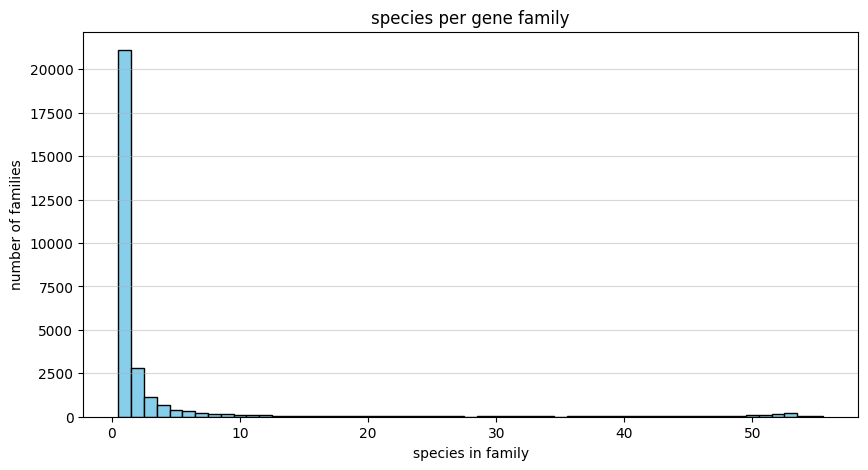

In [8]:
# plot

plt.figure(figsize=(10, 5))
plt.hist(counts, bins=range(min(counts), max(counts) + 2), color='skyblue', edgecolor='black', align='left')
plt.title("species per gene family")
plt.xlabel("species in family")
plt.ylabel("number of families")
plt.grid(axis='y', alpha=0.5)
plt.show()


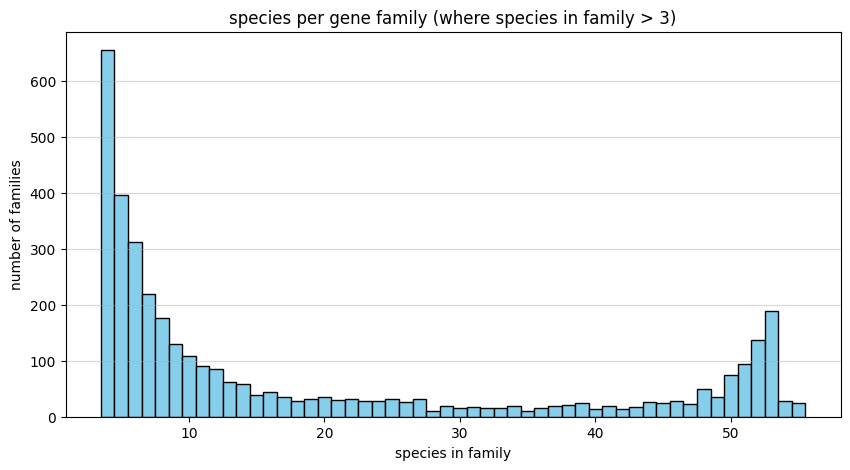

In [6]:

significant_counts = [i for i in counts if i>=4]

plt.figure(figsize=(10, 5))
plt.hist(significant_counts, bins=range(min(significant_counts), max(significant_counts) + 2), color='skyblue', edgecolor='black', align='left')
plt.title("species per gene family (where species in family > 3)")
plt.xlabel("species in family")
plt.ylabel("number of families")
plt.grid(axis='y', alpha=0.5)
plt.show()


In [12]:
iqtree_bin = "./iqtree-2.2.2.6-Linux/bin/iqtree2"
input_trees = "../trees/complete_families.newick"
out_dir = "../trees/consensus_trees"
log_dir = "../logs"

# dirs
os.makedirs(out_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# methods to run
methods = {
    "greedy": [],
    "majority": ["-minsup", "0.5"],
}

for name, flags in methods.items():
    print(f"computing {name}...")
    prefix = os.path.join(out_dir, name)
    
    # build command
    cmd = [iqtree_bin, "-con", "-t", input_trees, "--prefix", prefix, "--quiet"] + flags
    subprocess.run(cmd, check=True)
    
    # rename tree file
    if os.path.exists(f"{prefix}.contree"):
        os.rename(f"{prefix}.contree", f"{prefix}.tree")
        
    # move log file
    if os.path.exists(f"{prefix}.log"):
        shutil.move(f"{prefix}.log", os.path.join(log_dir, f"{name}_consensus.log"))

print(f"trees in {out_dir}, logs in {log_dir}")

computing greedy...
computing majority...
trees in ../trees/consensus_trees, logs in ../logs


# Analysis

In [14]:
import dendropy
import pandas as pd
import os

ref_path = "../literature/reference_tree.newick"
trees = {
    "Greedy consensus": "../trees/consensus_trees/greedy.tree",
    "Majority consensus": "../trees/consensus_trees/majority.tree",
    "Supertree (paralogs)": "../trees/supertrees/supertree_using_paralogs.tree",
    "Supertree (no paralogs)": "../trees/supertrees/supertree_no_paralogs.tree"
}

results = []

for name, path in trees.items():
    
    #load both into the same namespace so Dendropy recognizes identical species
    tns = dendropy.TaxonNamespace()
    t_ref = dendropy.Tree.get(path=ref_path, schema="newick", taxon_namespace=tns, preserve_underscores=True)
    t_test = dendropy.Tree.get(path=path, schema="newick", taxon_namespace=tns, preserve_underscores=True)
    
    #compute rf distance
    rf = dendropy.calculate.treecompare.symmetric_difference(t_ref, t_test)
    
    
    n_taxa = len(t_ref.taxon_namespace)

    #calculate max possible RF distance (2 * (n_taxa - 3))
    max_rf = 2 * (n_taxa - 3)

    #calculate similarity
    sim = (1 - rf/max_rf) * 100
    
    results.append({
        "Tree": name,
        "RF Distance": int(rf),
        "Similarity (%)": round(sim, 2)

    })
        
    

df = pd.DataFrame(results)
print(df.to_string(index=False))

                   Tree  RF Distance  Similarity (%)
       Greedy consensus           37           64.42
     Majority consensus           39           62.50
   Supertree (paralogs)           24           76.92
Supertree (no paralogs)           24           76.92


In [17]:
import toytree
import toyplot.html
from IPython.display import display, HTML

red_group = [
    "Bifidobacterium_actinocoloniiforme", "Bifidobacterium_asteroides", 
    "Bifidobacterium_coryneforme", "Bifidobacterium_indicum"
]
purple_group = [
    "Bifidobacterium_adolescentis", "Bifidobacterium_ruminantium", 
    "Bifidobacterium_catenulatum", "Bifidobacterium_kashiwanohense", 
    "Bifidobacterium_pseudocatenulatum", "Bifidobacterium_dentium", 
    "Bifidobacterium_moukalabense"
]
navy_group = [
    "Bifidobacterium_biavatii", "Bifidobacterium_hapali", 
    "Bifidobacterium_scardovii", "Bifidobacterium_bifidum"
]
lightblue_group = [
    "Bifidobacterium_aesculapii", "Bifidobacterium_stellenboschense", 
    "Bifidobacterium_callitrichos", "Bifidobacterium_angulatum", 
    "Bifidobacterium_merycicum", "Bifidobacterium_breve", 
    "Bifidobacterium_longum_subsp_infantis", "Bifidobacterium_longum_subsp_suis", 
    "Bifidobacterium_longum_subsp_longum", "Bifidobacterium_myosotis", 
    "Bifidobacterium_reuteri", "Bifidobacterium_saguini", 
    "Bifidobacterium_eulemuris", "Bifidobacterium_lemurum"
]
yellow_group = [
    "Bifidobacterium_gallinarum", "Bifidobacterium_pullorum"
]
lightgreen_group = [
    "Bifidobacterium_animalis_subsp_animalis", "Bifidobacterium_animalis_subsp_lactis", 
    "Bifidobacterium_choerinum", "Bifidobacterium_pseudolongum_subsp_globosum", 
    "Bifidobacterium_pseudolongum_subsp_pseudolongum", "Bifidobacterium_cuniculi", 
    "Bifidobacterium_gallicum", "Bifidobacterium_magnum"
]
darkgreen_group = [
    "Bifidobacterium_boum", "Bifidobacterium_thermacidophilum_subsp_porcinum", 
    "Bifidobacterium_thermophilum", "Bifidobacterium_thermacidophilum_subsp_thermacidophilum"
]

full_color_map = {}
for name in red_group: full_color_map[name] = "red"
for name in purple_group: full_color_map[name] = "purple"
for name in navy_group: full_color_map[name] = "navy"
for name in lightblue_group: full_color_map[name] = "#5DADE2"
for name in yellow_group: full_color_map[name] = "#F1C40F"
for name in lightgreen_group: full_color_map[name] = "#90EE90"
for name in darkgreen_group: full_color_map[name] = "#006400"

sorted_keys = sorted(full_color_map.keys(), key=len, reverse=True)

def get_color(tip_name):
    clean_tip = tip_name.strip().lower()
    for key in sorted_keys:
        if key.strip().lower() in clean_tip:
            return full_color_map[key]
    return "black"

trees_to_plot = {
    "Reference (Literature)": "../literature/reference_tree.newick",
    "Greedy Consensus": "../trees/consensus_trees/greedy.tree",
    "Majority Consensus": "../trees/consensus_trees/majority.tree",
    "Supertree (Paralogs)": "../trees/supertrees/supertree_using_paralogs.tree",
    "Supertree (No Paralogs)": "../trees/supertrees/supertree_no_paralogs.tree"
}

for name, path in trees_to_plot.items():
    display(HTML(f"<h3 style='font-family: monospace; margin-top: 30px;'>{name}</h3>"))
    try:
        t = toytree.tree(path)
        
        if name == "Reference (Literature)":
            original_order = t.get_tip_labels()
            colors = [get_color(n) for n in original_order]
            flipped_order = original_order[::-1]
            
            canvas, axes, mark = t.draw(
                layout='r', height=1000, width=700,
                tip_labels_align=True, 
                tip_labels_colors=colors,
                tip_labels_style={"font-size": "13px", "font-weight": "bold"},
                node_sizes=0,
                fixed_order=flipped_order
            )
        else:
            if "Scardovia_inopinata" in t.get_tip_labels():
                t = t.root("Scardovia_inopinata")
            elif "Bifidobacterium_asteroides" in t.get_tip_labels():
                t = t.root("Bifidobacterium_asteroides")
            
            t = t.ladderize()
            colors = [get_color(n) for n in t.get_tip_labels()]
            
            canvas, axes, mark = t.draw(
                layout='r', height=1000, width=700,
                tip_labels_align=True, 
                tip_labels_colors=colors,
                tip_labels_style={"font-size": "13px", "font-weight": "bold"},
                node_sizes=0
            )

        canvas.style["background-color"] = "white"
        canvas.style["border"] = "1px solid #ccc"
        toyplot.pdf.render(canvas, f"../trees/{name.replace(' ', '_').replace('(', '').replace(')', '')}.pdf")

        display(HTML(toyplot.html.tostring(canvas)))
        
    except Exception as e:
        print(f"Error plotting {name}: {e}")